# "Componenti principali e classificazione"
> "Classificare le azioni con tecniche di machine learning"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [jupyter, scikit-learn, finanza, pca, machine learning]
- image: images/2021-06-24-componenti-principali.png
- hide: false

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import altair as alt
import yfinance as yf

In [2]:
tickers = [
    'ENEL.MI',
    'ISP.MI',
    'STLA.MI',
    'ENI.MI',
    'UCG.MI',
    'G.MI',
    'RACE.MI',
    'STM.MI',
    'CNHI.MI',
    'MONC.MI',
    'SRG.MI',
    'FBK.MI',
    'TRN.MI',
    'NEXI.MI',
    'PRY.MI',
    'ATL.MI',
    'MB.MI',
    'EXO.MI',
    'CPR.MI',
    'AMP.MI'
]

In [3]:
data = yf.download(tickers=tickers, period='2y')
prices = data.xs('Adj Close', axis=1, level=0)
returns = prices.pct_change()
returns.head()

[*********************100%***********************]  20 of 20 completed


,AMP.MI,ATL.MI,CNHI.MI,CPR.MI,ENEL.MI,ENI.MI,EXO.MI,FBK.MI,G.MI,ISP.MI,MB.MI,MONC.MI,NEXI.MI,PRY.MI,RACE.MI,SRG.MI,STLA.MI,STM.MI,TRN.MI,UCG.MI
Date,,,,,,,,,,,,,,,,,,,,
2019-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-26,-0.018287,-0.043771,0.000673,-0.033576,-0.020319,0.004709,-0.004972,-0.008414,-0.003310,0.005031,0.020334,-0.007917,0.012129,-0.007092,-0.012363,-0.015003,0.001651,0.018494,-0.017194,0.025711
2019-06-27,-0.008824,-0.002641,0.007175,-0.006369,0.001482,-0.002895,0.022652,-0.006622,-0.003019,0.000426,0.006643,0.022014,0.008848,0.022857,0.007153,-0.015011,0.006758,0.016507,-0.011896,0.020699
2019-06-28,0.016815,0.011033,0.003784,0.004079,0.009204,0.009678,0.003257,0.021875,0.003028,0.001810,-0.002860,0.012386,0.005884,0.013966,0.014205,-0.020395,0.004093,0.013316,-0.008499,0.007070
2019-07-01,0.001945,-0.032300,0.013972,0.012188,-0.002280,0.002328,0.007792,0.005097,0.004227,-0.007651,-0.012795,0.010638,0.003532,0.007714,0.008754,-0.004805,0.006685,0.041987,-0.005714,-0.014964


In [4]:
corr_mat = returns.corr()

In [5]:
n_components = 6
pca = PCA(n_components=n_components)
pc = pca.fit_transform(corr_mat)
pc_df = pd.DataFrame(
    pc,
    returns.columns,
    [f'PC{c}' for c in range(n_components)]
)
pc_df.index.name = 'Titolo'
pc_df.head()

,PC0,PC1,PC2,PC3,PC4,PC5
Titolo,,,,,,
AMP.MI,0.689566,-0.279775,0.002989,-0.159081,-0.205828,-0.196607
ATL.MI,0.129037,-0.391033,0.666823,0.235798,0.019282,0.076259
CNHI.MI,-0.375289,-0.196707,0.144777,-0.163743,0.083959,0.250255
CPR.MI,0.640666,0.050260,0.137280,-0.324498,-0.007694,-0.141849
ENEL.MI,0.252291,0.388551,-0.028654,0.136458,-0.121697,0.049763


In [6]:
var_df = pd.DataFrame(
    pca.explained_variance_ratio_,
    pc_df.columns,
    ['Varianza cumulata']
)
var_df.index.name = 'PC'
alt.Chart(
    var_df.cumsum().reset_index()
).mark_bar().encode(
    y='PC:N',
    x='Varianza cumulata:Q',
    tooltip=['PC', 'Varianza cumulata']
).properties(
    title='Varianza cumulata spiegata dalle componenti principali'
).interactive()

alt.Chart(...)

In [7]:
alt.Chart(
    pc_df.reset_index().melt(
        'Titolo',
        var_name='PC',
        value_name='Esposizione'
    )
).mark_bar().encode(
    y='Titolo:N',
    x='Esposizione:Q',
    color='PC',
    row='PC',
    tooltip=['Titolo', 'PC', 'Esposizione']
).properties(
    title='Esposizione dei titoli alle componenti principali'
).interactive()

alt.Chart(...)

In [15]:
pc_px = returns.dot(pc_df).add(1).cumprod()
pc_px.iloc[0, :] = 1
alt.Chart(
    pc_px.reset_index().melt(
        'Date',
        var_name='PC',
        value_name='Prezzo'
    )
).mark_line().encode(
    x='Date:T',
    y='Prezzo:Q',
    color='PC:N',
    tooltip=['Date', 'PC', 'Prezzo']
).properties(
    title='Andamento delle componenti principali'
).interactive()

alt.Chart(...)

In [8]:
metrics_df = pd.DataFrame(
    index=range(2, 10),
    columns=['Inertia', 'Silhouette']
)
metrics_df.index.name = 'N_clusters'
for i in metrics_df.index:
    km = KMeans(n_clusters=i)
    km.fit_predict(pc_df)
    metrics_df.loc[i, 'Inertia'] = km.inertia_
    metrics_df.loc[i, 'Silhouette'] = silhouette_score(
        pc_df, 
        km.labels_, 
        metric='euclidean'
    )
metrics_df

,Inertia,Silhouette
N_clusters,,
2,4.262922,0.324135
3,3.020499,0.33362
4,2.341202,0.340727
5,1.708425,0.390867
6,1.310745,0.360813
7,1.002551,0.360073
8,0.739975,0.366402
9,0.630704,0.339042


In [9]:
n_clusters = 5
km_opt = KMeans(n_clusters=n_clusters)
clusters = km_opt.fit_predict(pc_df)
cl_df = pc_df.copy()
cl_df['Cluster'] = clusters
cl_df.head()

PC,PC0,PC1,PC2,PC3,PC4,PC5,Cluster
Titolo,,,,,,,
AMP.MI,0.689566,-0.279775,0.002989,-0.159081,-0.205828,-0.196607,3
ATL.MI,0.129037,-0.391033,0.666823,0.235798,0.019282,0.076259,4
CNHI.MI,-0.375289,-0.196707,0.144777,-0.163743,0.083959,0.250255,1
CPR.MI,0.640666,0.050260,0.137280,-0.324498,-0.007694,-0.141849,3
ENEL.MI,0.252291,0.388551,-0.028654,0.136458,-0.121697,0.049763,0


In [10]:
alt.Chart(
    cl_df.reset_index(),
).mark_circle().encode(
    x='PC0:Q',
    y='PC1:Q',
    color='Cluster:N',
    tooltip=['Titolo', 'Cluster']
).properties(
    title='Cluster rispetto alle prime due componenti principali'
).interactive()

alt.Chart(...)

In [45]:
wgt_df = pd.DataFrame(0.20 / cl_df['Cluster'].value_counts()).rename(columns={'Cluster': 'Peso'})

In [46]:
pesi = pd.DataFrame(index=cl_df.index, columns=['Equal', 'Clustered'])
pesi.Equal = 0.05
pesi.Clustered = cl_df.Cluster.map(wgt_df.Peso)

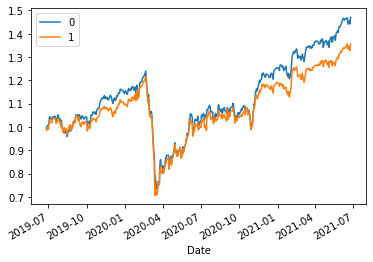

In [47]:
pd.concat([
    returns.dot(pesi.Equal).add(1).cumprod(),
    returns.dot(pesi.Clustered).add(1).cumprod()
], axis=1).plot();

<AxesSubplot:xlabel='Date'>

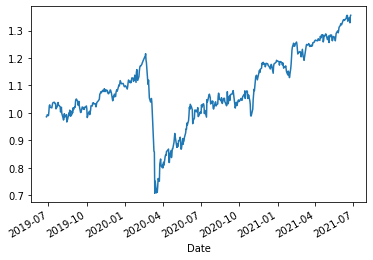

In [37]:
.plot()